In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise_generator import GenerateNoise
import qutip as qt

In [4]:
sample_rate = 1               # per ns
tnoise_max = int(1e6)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-3
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)

In [5]:
trajs = gn.generate_colored_noise()

Sanity Checks (1/f noise):
PSD fit: power = -0.9999, intercept = -6.6398, R² = 0.9990, S0 = 1.909991e-04


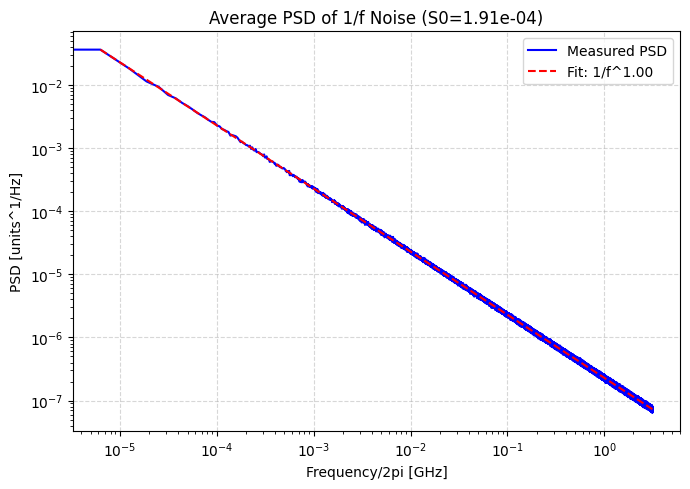

In [6]:
S0 = gn.analyze_noise_psd(trajs)

In [7]:
S0

np.float64(0.0001909990588171107)

In [8]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [[qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points, e_ops=[sigma_x])
    
    # Store the expectation values
    all_expect_values.append(result.expect[0])

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


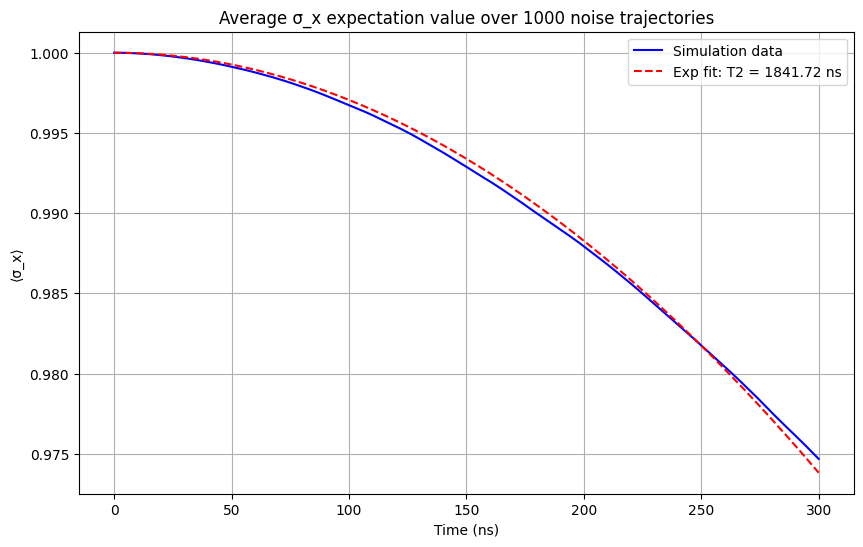

Fitted T2 time = 1841.7211 ns


In [9]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay(t, T2):
    return np.exp(-t**2/ T2**2)  # No amplitude parameter

# Fit the data with exponential decay
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_sigmax, p0=[1000])
T2_fit = params[0]

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")


In [10]:
T2_fit

np.float64(1841.7211498907268)

In [11]:
1/(S0*np.sqrt(2)*np.sqrt(abs(np.log(omega_ir*t_max))))

np.float64(1478.0416567061413)